## Survivor Data Modeling

### Import Dependencies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import DataConversionWarning

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sys
import warnings
import math
import os
import random

warnings.filterwarnings("ignore", category=DataConversionWarning)

# Get the current working directory
current_dir = os.getcwd()

# Get the path to the survivorData directory
data_dir = os.path.join(current_dir, '..', 'survivorData')

### Read in csv files as Dataframes

In [2]:
# List of CSV file names
csv_files = [
    'advantage_movement.csv',
    'boot_mapping.csv',
    'castaways.csv',
    'castaway_details.csv',
    'challenge_description.csv',
    'challenge_results.csv',
    'confessionals.csv',
    'jury_votes.csv',
    'screen_time.csv',
    'season_palettes.csv',
    'season_summary.csv',
    'survivor_auction.csv',
    'tribe_colours.csv',
    'tribe_mapping.csv',
    'viewers.csv',
    'vote_history.csv'
]

# Create a dictionary to store the DataFrames
dataframes = {}

# Loop through each CSV file and read its data into a DataFrame
for csv_file in csv_files:
    # Specify the relative path to the CSV file
    file_path = os.path.join(data_dir, csv_file)
    
    # Read the data from the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Store the DataFrame in the dictionary
    dataframes[csv_file] = df

### Clean up the data and feature engineer

In [3]:
# Convert tribe_status column to category type
dataframes['tribe_colours.csv']['tribe_status'] = dataframes['tribe_colours.csv']['tribe_status'].astype('category')

# Convert result to a categorical variable
dataframes['castaways.csv']['result'] = pd.Categorical(dataframes['castaways.csv']['result'])
dataframes['castaways.csv']['result'] = dataframes['castaways.csv']['result'].cat.codes

# Merge challenge_results and castaway_details dataframes on castaway_id
castawayAll = pd.merge(dataframes['castaways.csv'], dataframes['castaway_details.csv'], on='castaway_id', how ="left")

castawayAll['genderNumber'] = np.where(castawayAll['gender'] == 'Male', 1,
                                     np.where(castawayAll['gender'] == 'Female', 2,
                                              np.where(castawayAll['gender'] == 'Non-binary', 3, 0)))
castawayAll['won'] = np.where(castawayAll['result'] == 'Sole Survivor', 1, 0)

castawayAll = castawayAll.dropna(subset=['age'])

# Drop rows where 'season' is equal to 44
castawayAll = castawayAll[castawayAll['season'] != 44]

print(castawayAll['castaway_id'])

0       AU0001
1       AU0002
2       AU0003
3       AU0004
4       AU0005
         ...  
1181    US0636
1182    US0634
1183    US0642
1184    US0627
1185    US0638
Name: castaway_id, Length: 1186, dtype: object


## Additional feature engineering for challenge results data integrated into the modeling code

In [4]:
# Read the challenge_results.csv file
challenge_results = dataframes['challenge_results.csv']

# Filter out the rows where challenge_type is "Immunity" and the result is "Won"
immunity_wins = challenge_results[(challenge_results['challenge_type'] == 'Immunity') & (challenge_results['result'] == 'Won')]

#print(immunity_wins['castaway_id'])

# Group by 'castaway_id' and count the number of immunity wins
immunity_counts = immunity_wins.groupby('castaway_id').size()

# Convert Series to DataFrame
immunity_counts_df = immunity_counts.reset_index(name='wonImmunity')

print(immunity_counts_df.columns)
print(immunity_counts_df['wonImmunity'])

# Set 'castaway_id' as the index for easier merging later
immunity_counts_df.set_index('castaway_id', inplace=True)

# Assuming 'castawayAll' is your original DataFrame and it also has 'castaway_id' as index
castawayAll = castawayAll.join(immunity_counts_df)

# Fill NaN values with 0 - assuming that contestants who didn't win any immunity challenges are not present in the immunity_counts_df DataFrame
castawayAll['wonImmunity'].fillna(0, inplace=True)

#print(castawayAll['wonImmunity'].value_counts())

# Once implemented, we can add this data to the x_train and x_test
# # When creating your training and testing datasets, you should now include 'wonImmunity' as a feature
# x_train = pd.concat([season_split[i][['age', 'genderNumber', 'wonImmunity']] for i in train_index])
# x_test = pd.concat([season_split[i][['age', 'genderNumber', 'wonImmunity']] for i in test_index])



8        AU0002
9        AU0004
10       AU0005
11       AU0006
12       AU0009
          ...  
18102    US0653
18103    US0654
18104    US0656
18105    US0646
18134    US0648
Name: castaway_id, Length: 3259, dtype: object


## Predicting Color Values in the survivor dataset: A Comparative Analysis of SVM and Logistic Regression Models

### Introduction:
In this overview, we will delve into the rationale behind predicting color values in a dataset and explore the unique situation it presents when it comes to quantifying results. Specifically, we will compare the performance of Support Vector Machine (SVM) and Logistic Regression models in predicting color values and evaluate the effectiveness of various metrics such as average accuracy, Hamming distance, and Euclidean distance.

### Predicting Color Values in a Dataset:
Color is an essential aspect of visual data analysis and has a wide range of applications, including image processing, computer vision, and data visualization. By predicting color values in a dataset, we can gain insights into patterns, trends, and relationships that are not immediately apparent to the human eye. This predictive modeling approach allows us to develope skills to uncover hidden information and make data-driven decisions.

### Comparison of SVM and Logistic Regression Models:
To determine the best approach for predicting color values, we have chosen to compare the performance of two popular machine learning algorithms: Support Vector Machine (SVM) and Logistic Regression. Both models are widely used in classification tasks and have demonstrated success in various domains.

1. Support Vector Machine (SVM):
SVM is a powerful algorithm that aims to find an optimal hyperplane in a high-dimensional feature space. It separates data points into distinct classes by maximizing the margin between them. SVM is known for its ability to handle complex datasets and nonlinear relationships effectively. Its versatility and robustness make it a suitable candidate for predicting color values in a dataset.

2. Logistic Regression:
Logistic Regression is a probabilistic machine learning algorithm used for binary classification tasks. It models the relationship between the input features and the probability of a particular outcome. Logistic Regression is known for its simplicity, interpretability, and efficiency. While it may not capture complex nonlinear relationships as effectively as SVM, it can still yield accurate predictions in certain scenarios.

### Quantifying Results:
To evaluate the performance of our SVM and Logistic Regression models in predicting color values, we will utilize several metrics that address different aspects of model performance:

1. Average Accuracy:
Average accuracy measures the percentage of correctly classified instances across all classes.

2. Hamming Distance:
Hamming distance quantifies the dissimilarity between two color values by measuring the number of positions at which they differ. Since color values can be represented as vectors in a multi-dimensional space, Hamming distance provides a useful metric for evaluating the similarity or dissimilarity of predicted colors.

3. Euclidean Distance:
Euclidean distance measures the straight-line distance between two points in a multi-dimensional space. In the context of color values, Euclidean distance allows us to determine the proximity of predicted colors to the ground truth. 

### Conclusion:
Predicting color values in a dataset presents a unique situation due to its visual and perceptual nature. By comparing the performance of SVM and Logistic Regression models, we can gain insights into the effectiveness of these algorithms in accurately predicting color values. Furthermore, by utilizing metrics such as average accuracy, Hamming distance, and Euclidean distance, we can comprehensively evaluate the performance of the models and make informed decisions regarding their suitability for color prediction tasks.



## Color prediction with SVM model

In [5]:
# Prepare the data for training
X = dataframes['tribe_colours.csv']['tribe_status'].values.reshape(-1, 1)
y = dataframes['tribe_colours.csv']['tribe_colour']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create an SVM model
svm_model = svm.SVC()

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_svm)

# Calculate Hamming distance for all predictions
hamming_distances = []

for idx in range(len(y_pred)):
    hamming_dist = sum(el1 != el2 for el1, el2 in zip(y_pred[idx], y_test.iloc[idx]))
    hamming_distances.append(hamming_dist)

# Calculate average Hamming distance for incorrect predictions
avg_hamming_distance_svm = np.mean(hamming_distances)

# The Hamming distance measures the dissimilarity between two strings of equal length. In the context of hex color values, 
# each character represents a component of the color (e.g., red, green, and blue), and the Hamming distance calculates 
# the number of positions at which the predicted and actual color values differ.

# Since hex color values consist of six characters (e.g., #RRGGBB), the Hamming distance for hex color values can range from 0 to 6.

# Print average Hamming distance for incorrect predictions
print("Average Hamming Distance for Incorrect Predictions:", avg_hamming_distance_svm)

# Calculate Euclidean distance for color similarity
euclidean_distances = []
for idx in range(len(y_pred)):
    predicted_color = y_pred[idx][1:]  # Remove the "#" character from the predicted color
    actual_color = y_test.iloc[idx][1:]  # Remove the "#" character from the actual color
    
    # Convert hex color values to RGB tuples
    predicted_rgb = tuple(int(predicted_color[i:i+2], 16) for i in (0, 2, 4))
    actual_rgb = tuple(int(actual_color[i:i+2], 16) for i in (0, 2, 4))
    
    # Calculate Euclidean distance between RGB tuples
    distance = math.sqrt(sum((p - a) ** 2 for p, a in zip(predicted_rgb, actual_rgb)))
    euclidean_distances.append(distance)

# Calculate average Euclidean distance for all predictions
avg_euclidean_distance_svm = np.mean(euclidean_distances)

# The Euclidean distance measures the spatial or geometric distance between two colors in the RGB color space.
# In the RGB color space, each color is represented by three components: red (R), green (G), and blue (B). 
# The Euclidean distance calculates the straight-line distance between two colors in this three-dimensional space.

# Print average Euclidean distance for all predictions
print("Average Euclidean Distance for All Predictions:", avg_euclidean_distance_svm)

Accuracy: 0.15217391304347827
Average Hamming Distance for Incorrect Predictions: 4.5
Average Euclidean Distance for All Predictions: 226.65027241161368


c:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\__init__.py:202: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return array[key] if axis == 0 else array[:, key]


## Color prediction with logistic regression model

In [6]:
# Create a Logistic Regression model
logreg_model = LogisticRegression()

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Calculate accuracy
accuracy_logistic_regression = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_logistic_regression)

# Calculate Hamming distance for all predictions
hamming_distances = []

for idx in range(len(y_pred)):
    hamming_dist = sum(el1 != el2 for el1, el2 in zip(y_pred[idx], y_test.iloc[idx]))
    hamming_distances.append(hamming_dist)

# Calculate average Hamming distance for incorrect predictions
avg_hamming_distance_logistic_regression = np.mean(hamming_distances)

# The Hamming distance measures the dissimilarity between two strings of equal length. In the context of hex color values, 
# each character represents a component of the color (e.g., red, green, and blue), and the Hamming distance calculates 
# the number of positions at which the predicted and actual color values differ.

# Since hex color values consist of six characters (e.g., #RRGGBB), the Hamming distance for hex color values can range from 0 to 6.

# Print average Hamming distance for incorrect predictions
print("Average Hamming Distance for Incorrect Predictions:", avg_hamming_distance_logistic_regression)

# Calculate Euclidean distance for color similarity
euclidean_distances = []
for idx in range(len(y_pred)):
    predicted_color = y_pred[idx][1:]  # Remove the "#" character from the predicted color
    actual_color = y_test.iloc[idx][1:]  # Remove the "#" character from the actual color
    
    # Convert hex color values to RGB tuples
    predicted_rgb = tuple(int(predicted_color[i:i+2], 16) for i in (0, 2, 4))
    actual_rgb = tuple(int(actual_color[i:i+2], 16) for i in (0, 2, 4))
    
    # Calculate Euclidean distance between RGB tuples
    distance = math.sqrt(sum((p - a) ** 2 for p, a in zip(predicted_rgb, actual_rgb)))
    euclidean_distances.append(distance)

# Calculate average Euclidean distance for all predictions
avg_euclidean_distance_logistic_regression = np.mean(euclidean_distances)

# The Euclidean distance measures the spatial or geometric distance between two colors in the RGB color space.
# In the RGB color space, each color is represented by three components: red (R), green (G), and blue (B). 
# The Euclidean distance calculates the straight-line distance between two colors in this three-dimensional space.

# Print average Euclidean distance for all predictions
print("Average Euclidean Distance for All Predictions:", avg_euclidean_distance_logistic_regression)

Accuracy: 0.13043478260869565
Average Hamming Distance for Incorrect Predictions: 4.630434782608695
Average Euclidean Distance for All Predictions: 233.91612564936852


c:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Color prediction model comparision

Upon examining the graph plotted on a logarithmic scale, which enhances the visual representation of metric differences, a notable observation arises: the accuracy of the SVM model surpasses that of the Logistic Regression model by a significant margin. However, when considering the average Hamming distance and average Euclidean distance metrics, the difference between the two models is negligible.

This log scale representation allows for a clearer visualization of the relative differences between the metrics. It accentuates the disparity in accuracy between SVM and Logistic Regression, emphasizing the stronger performance of SVM in terms of overall correct predictions. At the same time, the log scale helps highlight the close proximity of the two models in terms of the average Hamming distance and average Euclidean distance, indicating similar abilities to capture the patterns and relationships within the data.

Therefore, taking into account the log scale representation, the graph reaffirms that SVM excels in accuracy compared to Logistic Regression, while both models demonstrate comparable results in terms of capturing the similarity between predicted and actual values.

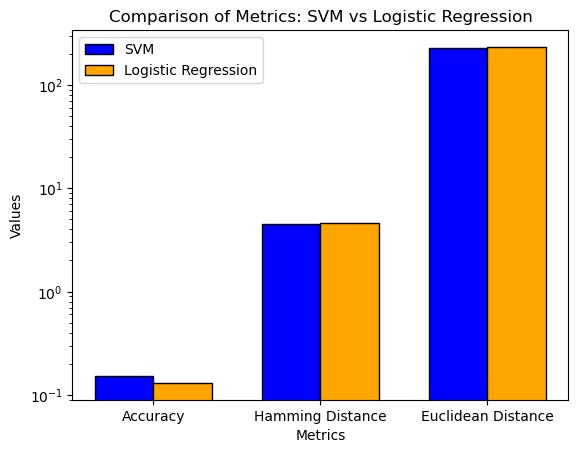

In [7]:
# Define the metrics for SVM
svm_metrics = {
    'Accuracy': accuracy_svm,
    'Hamming Distance': avg_hamming_distance_svm,
    'Euclidean Distance': avg_euclidean_distance_svm
}

# Define the metrics for Logistic Regression
logreg_metrics = {
    'Accuracy': accuracy_logistic_regression,
    'Hamming Distance': avg_hamming_distance_logistic_regression,
    'Euclidean Distance': avg_euclidean_distance_logistic_regression
}

# Create a list of metric names
metrics = list(svm_metrics.keys())

# Create a list of SVM metric values
svm_values = list(svm_metrics.values())

# Create a list of Logistic Regression metric values
logreg_values = list(logreg_metrics.values())

# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = range(len(metrics))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, svm_values, color='blue', width=bar_width, edgecolor='black', label='SVM')
plt.bar(r2, logreg_values, color='orange', width=bar_width, edgecolor='black', label='Logistic Regression')

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Metrics: SVM vs Logistic Regression')
plt.xticks([r + bar_width/2 for r in range(len(metrics))], metrics)
plt.legend()

# Set the y-axis scale to logarithmic
plt.yscale('log')

# Display the plot
plt.show()


## Model analysis

### SVM interpretation

The repeated occurrence of '7' as the chosen support vector suggests that instances with this specific feature value hold significant importance in the classification task. The value '7' plays a crucial role in determining the decision boundary between the classes, indicating that instances associated with '7' have distinct characteristics that differentiate them from other data points. These instances strongly influence the SVM model's predictions and contribute significantly to the separation of the classes. Overall, the repeated appearance of '7' as support vectors indicates its relevance and influence in the classification process.

### Logistic regression interpretation

The weight (coefficient) for 'tribe_status' is -0.67694186. In logistic regression, the coefficients represent the impact of each feature on the predicted probability of the target variable.

Since 'tribe_status' is a categorical feature, it likely represents different categories or groups within the data. In this case, the weight of -0.67694186 indicates the effect of each unit change in the 'tribe_status' feature on the log-odds of the target variable.

Specifically, for each unit increase in 'tribe_status', the log-odds of the target variable decrease by approximately 0.67694186. This suggests that higher values of 'tribe_status' are associated with a lower likelihood or probability of the target variable.

In [8]:
# Retrieve the indices of the support vectors
support_vector_indices = svm_model.support_

# Retrieve the support vectors from the training set
support_vectors = X_train[support_vector_indices]

# Print the support vectors
print("Chosen Support Vectors:")
for vector in support_vectors:
    print(vector)

# Retrieve the learned coefficient from the logistic regression model
coefficient = logreg_model.coef_[0]

# Print the weight for the feature
print(f"Weight for 'tribe_status': {coefficient}")

Chosen Support Vectors:
[7]
[7]
[7]
[6]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[11]
[6]
[7]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[6]
[7]
[7]
[6]
[7]
[7]
[11]
[11]
[7]
[7]
[11]
[6]
[7]
[11]
[7]
[7]
[7]
[6]
[6]
[7]
[11]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[6]
[6]
[6]
[7]
[7]
[7]
[6]
[7]
[6]
[11]
[7]
[7]
[7]
[7]
[7]
[7]
[0]
[6]
[7]
[7]
[7]
[7]
[10]
[3]
[8]
[1]
[7]
[7]
[7]
[7]
[7]
[6]
[11]
[7]
[11]
[6]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[6]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[6]
[7]
[7]
[6]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[6]
[6]
[7]
[7]
[6]
[7]
[7]
[6]
[6]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[6]
Weight for 'tribe_status': [-0.51808479]


## Simulation of survivor seasons and predicting the order in which people leave the game

The simulation model employed in this code is well-suited for the given dataset, which corresponds to the TV show Survivor. In Survivor, contestants are eliminated one by one, and an obvious objective is to predict the next person who will leave the show. To ensure accurate predictions, it is crucial to consider only the remaining contestants at each stage, as those who have already been eliminated would not contribute to the decision-making process.

The code implements a leave-one-group-out cross-validation technique, which aligns with the Survivor format. Each iteration of the cross-validation loop represents a new stage of the show, where a group of contestants is considered for prediction while excluding the others who have already been eliminated. This simulation approach ensures that the predictions are based on the available pool of contestants, mimicking the progression of the actual show.

By training and evaluating the SVM and logistic regression models on the remaining contestants in each iteration, the simulation model captures the dynamic nature of Survivor, where the characteristics and interactions among the remaining contestants influence the prediction outcomes. The model predicts the "orderOut" values (the order of elimination) for the test set, and the accuracy of the predicted outcomes is calculated against the true outcomes.

Overall, this simulation model ideologically aligns with Survivor by accounting for the evolving dynamics of the show, focusing on the remaining contestants, and predicting their order of elimination. It ensures that predictions are based on the relevant subset of contestants and provides a practical and effective approach for forecasting the outcomes in the context of the TV show Survivor.

## Status of capabilities

The provided code is still a work in progress and requires further refinement to ensure accurate incorporation of the concept of considering only the remaining contestants at each stage. Adjustments and modifications are needed to improve the code's adherence to the elimination rules of the Survivor show.

Additionally, fine-tuning the model's parameters and implementing appropriate data preprocessing techniques are essential steps to enhance the accuracy of the predictions. While progress has been made in filtering out eliminated contestants from the prediction process, further testing and evaluation are necessary to ensure the logic is robust and reliable.

Another important aspect that requires attention is the handling of missing or incomplete data. Devising effective strategies to address missing values and ensuring the completeness of the dataset will contribute to more accurate predictions.

Ongoing development and iterative improvements are crucial to align the simulation model more closely with the actual progression of the Survivor TV show. Through these efforts, meaningful insights can be provided, enabling better predictions of the order of elimination

## Goals:

1. Robust Testing: You aim to set up more comprehensive testing to verify that the simulation is working as intended. This will involve designing test cases that cover various scenarios and edge cases to ensure the code handles them correctly. By systematically testing different input scenarios, you can gain confidence in the accuracy and reliability of the simulation.

2. Updating x_test DataFrame: You plan to update the x_test DataFrame with data from previous events of the current season. This step involves formatting the CSV file to include the necessary additional data. You need to determine the appropriate format and structure of the CSV file to incorporate this information. Consider organizing the data in a way that allows easy merging or concatenation with the existing DataFrame to enrich the features used for prediction.

3. Presentable Testing Results: You want to organize the testing results in a presentable format, including a learning curve, confidence intervals between different models tested, and other useful conclusions. This will involve analyzing the performance metrics obtained from the testing process, such as accuracy, and presenting them in a visually appealing manner. Additionally, you can explore techniques such as learning curves, which illustrate the model's performance as the amount of training data increases.

In [9]:
# Use a random forest model that tries to predict the order the remaining contestants will be eliminated from the show.
#       Return the contestant remaining that has the lowest orderOut prediction
#       An orderOut value of 1 means that person was the first eleminated and the hightest orderOut in that season is the winner
#       x_train is the age and gender of contestants in the training set
#       y_train is the orderOut for contestants in the training set
#       current_order is the orderOut value that is being predicted
def person_prediction(remaining_contestants, x_train_current, y_train_current, current_order):
    # Train the random forest model
    model = RandomForestClassifier()
    model.fit(x_train_current, y_train_current)
    
    # print("----------------")
    # print(len(remaining_contestants))
    # print("----------------")

    # Predict the order for the remaining contestants
    x_test_current = remaining_contestants[['age', 'genderNumber']]
    predicted_order = model.predict(x_test_current)

    # Find the contestants with the smallest predicted order
    min_predicted_order = np.min(predicted_order)
    contestants_with_min_order = np.where(predicted_order == min_predicted_order)[0]

    # Randomly select one contestant from those with the smallest predicted order
    person_predicted = np.random.choice(contestants_with_min_order)

    return person_predicted

# Split dataframe into a list of dataframes grouped by column name
def split_dataframe(df, column_name):
    groups = df.groupby(column_name)
    result = [group for _, group in groups]
    return result

# Call split_dataframe on column name "version_season"
season_split = split_dataframe(castawayAll, 'version_season')

# Give each contestant which order they were eliminated from the show
for df in season_split:
    df['orderOut'] = range(1, len(df) + 1)

# Perform leave one group out cross-validation on the remaining code

# Perform leave-one-group-out cross-validation
logo = LeaveOneGroupOut()

# Create a list of group labels corresponding to each DataFrame in season_split
group_labels = [i for i, _ in enumerate(season_split)]

print(len(season_split))
print(len(group_labels))

accuracies = []  # Create an empty list to store accuracies

for train_index, test_index in logo.split(season_split, groups=group_labels):

    x_train = pd.concat([season_split[i][['age', 'genderNumber']] for i in train_index])
    y_train = pd.concat([season_split[i][['orderOut']] for i in train_index])

    x_test = pd.concat([season_split[i][['age', 'genderNumber']] for i in test_index])
    y_test = pd.concat([season_split[i][['orderOut']] for i in test_index])

    number_of_contestants = len(x_test)
    order_out = 1
    correct_predictions = 0

    while len(x_test) > 0:
        age_eliminated = x_test.iloc[0]['age']
        gender_number_eliminated = x_test.iloc[0]['genderNumber']
        # Print the values for the person who was eliminated
        #print("Person eliminated:")
        #print(f"Age: {age_eliminated}, Gender Number: {gender_number_eliminated}, Order Out: {order_out}")
        
        # Select a person
        prediction_person_index = person_prediction(x_test, x_train, y_train, order_out)
        # print("-------------------------------------")
        # print(x_test)
        # print(f"Person prediction position: {prediction_person_index}")
        # print(f"Person prediction age: {x_test.iloc[prediction_person_index]['age']}")
        
        # print(f"Person eleminated position: {prediction_person_index}")
        # print(f"Person eleminated age: {age_eliminated}")
        # print("-------------------------------------")
        # Check if the prediction is correct
        if prediction_person_index == 0:
            correct_predictions += 1
            
        #TODO:: Update x_train and y_train to include the person who is dropping out
        
        # Remove the first element of x_test
        x_test = x_test.iloc[1:]
        order_out = order_out + 1

    # Calculate and print the accuracy of the model
    print("----------")
    print(number_of_contestants)
    accuracy = (correct_predictions / number_of_contestants) * 100
    accuracies.append(accuracy)
    print(f"Model Accuracy: {accuracy}%")
    print("----------")
    
print(x_test)
print(y_test)
print(accuracies)


61
61
----------
24
Model Accuracy: 12.5%
----------
----------
24
Model Accuracy: 8.333333333333332%
----------
----------
25
Model Accuracy: 12.0%
----------
----------
25
Model Accuracy: 12.0%
----------
----------
24
Model Accuracy: 8.333333333333332%
----------
----------
26
Model Accuracy: 19.230769230769234%
----------
----------
28
Model Accuracy: 7.142857142857142%
----------
----------
25
Model Accuracy: 16.0%
----------
----------
19
Model Accuracy: 21.052631578947366%
----------
----------
16
Model Accuracy: 12.5%
----------
----------
16
Model Accuracy: 12.5%
----------
----------
18
Model Accuracy: 5.555555555555555%
----------
----------
19
Model Accuracy: 10.526315789473683%
----------
----------
20
Model Accuracy: 25.0%
----------
----------
18
Model Accuracy: 11.11111111111111%
----------
----------
21
Model Accuracy: 23.809523809523807%
----------
----------
20
Model Accuracy: 20.0%
----------
----------
20
Model Accuracy: 20.0%
----------
----------
16
Model Accurac

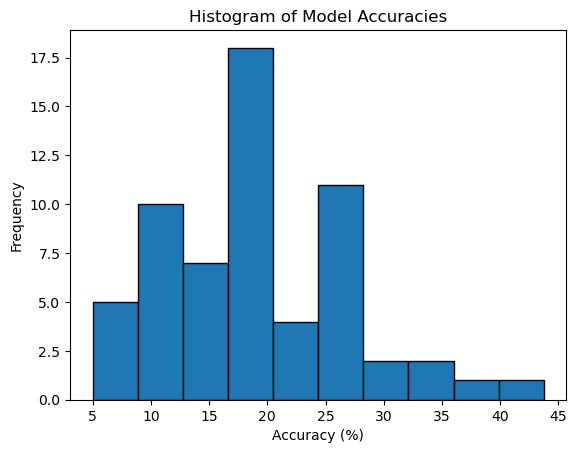

In [10]:
plt.hist(accuracies, bins=10, edgecolor='black')
plt.title('Histogram of Model Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Frequency')
plt.show()

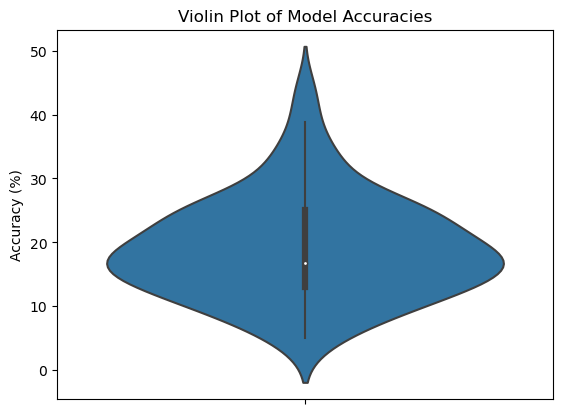

In [11]:
sns.violinplot(y=accuracies)
plt.title('Violin Plot of Model Accuracies')
plt.ylabel('Accuracy (%)')
plt.show()

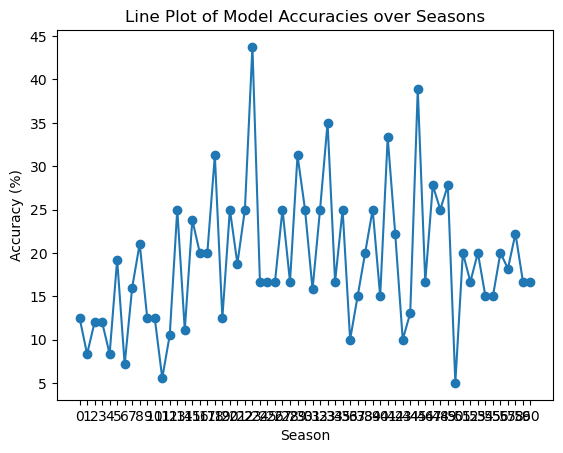

In [12]:
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.title('Line Plot of Model Accuracies over Seasons')
plt.xlabel('Season')
plt.ylabel('Accuracy (%)')
plt.xticks(ticks=range(1, len(accuracies) + 1), labels=group_labels)
plt.show()

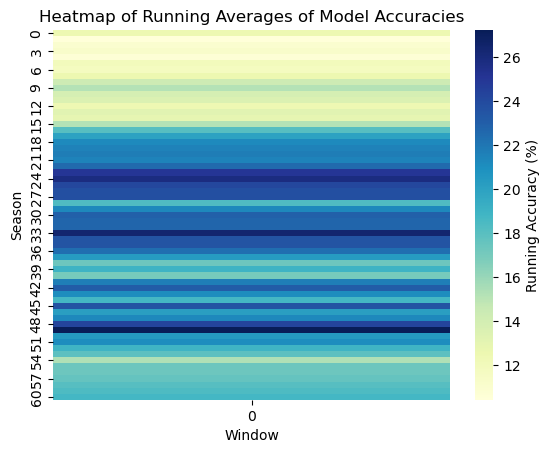

In [13]:
# Compute running averages over a window of 5 seasons
window_size = 5
running_averages = [np.mean(accuracies[max(0, i-window_size+1):i+1]) for i in range(len(accuracies))]

# Create a 2D array for the heatmap
heatmap_data = np.array(running_averages).reshape(-1, 1)

# Create a heatmap
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label': 'Running Accuracy (%)'})
plt.title('Heatmap of Running Averages of Model Accuracies')
plt.xlabel('Window')
plt.ylabel('Season')
plt.show()

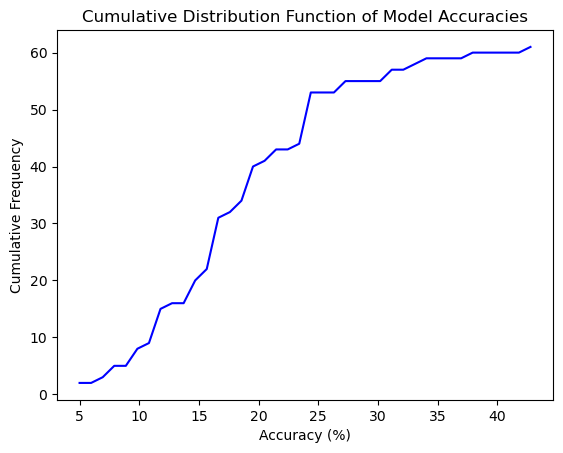

In [14]:
# Compute CDF
values, base = np.histogram(accuracies, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='blue')
plt.title('Cumulative Distribution Function of Model Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Cumulative Frequency')
plt.show()

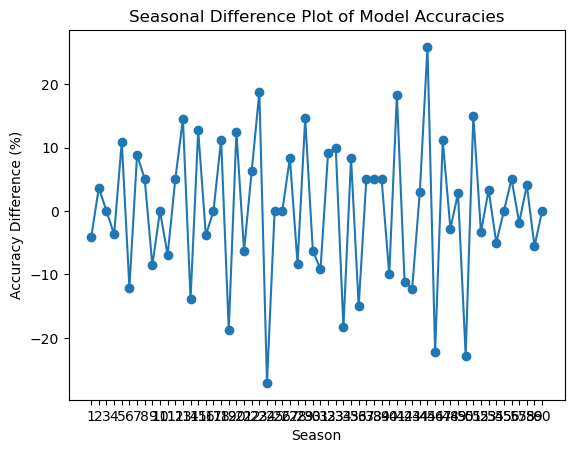

In [15]:
# Compute differences
differences = [j - i for i, j in zip(accuracies[:-1], accuracies[1:])]

plt.plot(range(1, len(differences) + 1), differences, marker='o')
plt.title('Seasonal Difference Plot of Model Accuracies')
plt.xlabel('Season')
plt.ylabel('Accuracy Difference (%)')
plt.xticks(ticks=range(1, len(differences) + 1), labels=group_labels[1:])
plt.show()